Notebook exploring how to plot entity data via the HA restul API, as a means to avoid the need to a recorder and SQL queries.

In [1]:
from requests import get, post
import json
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import datetime as dt
from fbprophet import Prophet
import pandas as pd
import datetime as dt
import urllib.parse
from urllib.parse import urlencode, quote_plus
%matplotlib inline

def print_json(json_data):
    PrettyPrinter().pprint(json_data)
    
# for loading credentials    
def load_credentials(filename):
    try:
        with open(filename, 'r') as fp:
            data = json.load(fp)
    except Exception as e:
        print('Failed to load data')
        data = None
    return data

# Need to load in my HA URL and password
filename = '/Users/robincole/Desktop/hass_url.json'
creds = load_credentials(filename) 
password = creds['password']  # My HA password
url = creds['url']  # My HA password

headers = {'content-type': 'application/json', 
           'x-ha-access': password}

In [2]:
entity = 'sensor.darksky_sensor_temperature'  # The sensor I wish to plot

In [3]:
query_days = 10
lookback_period = (dt.datetime.now() - timedelta(days=query_days)).isoformat() 
lookback_period

'2018-01-11T17:48:55.016502'

In [77]:
%%time
# OK now lets query the HA API with an end_time
now_encoded = urllib.parse.quote_plus(datetime.now().isoformat())
query = '{}api/history/period/{}?end_time={}'.format(url, lookback_period, now_encoded)
response = get(query, headers=headers).json()

CPU times: user 960 ms, sys: 482 ms, total: 1.44 s
Wall time: 1min 25s


In [78]:
query

'http://192.168.0.30:8123/api/history/period/2018-01-11T17:48:55.016502?end_time=2018-01-21T20%3A37%3A39.483350'

In [79]:
response[0:10]

[[{'attributes': {'friendly_name': 'Alarm_on_automation',
    'id': '1503121451330',
    'last_triggered': None},
   'entity_id': 'automation.alarm_on_automation',
   'last_changed': '2018-01-11T17:48:55.016502+00:00',
   'last_updated': '2018-01-11T17:48:55.016502+00:00',
   'state': 'on'},
  {'attributes': {'friendly_name': 'Alarm_on_automation',
    'id': '1503121451330',
    'last_triggered': None},
   'entity_id': 'automation.alarm_on_automation',
   'last_changed': '2018-01-16T07:29:36.625056+00:00',
   'last_updated': '2018-01-16T07:29:36.625056+00:00',
   'state': 'off'},
  {'attributes': {'friendly_name': 'Alarm_on_automation',
    'id': '1503121451330',
    'last_triggered': None},
   'entity_id': 'automation.alarm_on_automation',
   'last_changed': '2018-01-16T07:29:44.921988+00:00',
   'last_updated': '2018-01-16T07:29:44.921988+00:00',
   'state': 'on'},
  {'attributes': {'friendly_name': 'Alarm_on_automation',
    'id': '1503121451330',
    'last_triggered': None},
   'en

### I should be able to define both entities and end_time??? 

In [60]:
%%time
# OK now lets query the HA API with an end_time
now_encoded = urllib.parse.quote_plus(datetime.now().isoformat())
query = '{}api/history/period/{}?end_time={}?filter_entity_id={}'.format(url, lookback_period, now_encoded, entity)
response = get(query, headers=headers).json()

CPU times: user 6 ms, sys: 10.4 ms, total: 16.4 ms
Wall time: 22.4 ms


In [82]:
%%time
# OK now lets query the HA API with an end_time
now_encoded = urllib.parse.quote_plus(datetime.now().isoformat())
query = '{}api/history/period/{}'.format(url, lookback_period)
payload = {"end_time": now_encoded, "filter_entity_id": entity}
response = get(query, headers=headers, params = payload).json()

CPU times: user 5.65 ms, sys: 9.44 ms, total: 15.1 ms
Wall time: 1.08 s


In [83]:
payload

{'end_time': '2018-01-21T20%3A41%3A00.565449',
 'filter_entity_id': 'sensor.darksky_sensor_temperature'}

In [84]:
response

{'message': 'Invalid end_time'}

In [41]:
data = response[0]

In [42]:
len(data)

18

In [47]:
data[4]

{'attributes': {'friendly_name': 'Alarm_on_automation',
  'id': '1503121451330',
  'last_triggered': None},
 'entity_id': 'automation.alarm_on_automation',
 'last_changed': '2018-01-16T07:34:32.816781+00:00',
 'last_updated': '2018-01-16T07:34:32.816781+00:00',
 'state': 'on'}

In [6]:
%%time
# OK lets drop the end_time
query = '{}api/history/period/{}?filter_entity_id={}'.format(url, lookback_period, entity)
response = get(query, headers=headers).json()

CPU times: user 5.6 ms, sys: 2.26 ms, total: 7.86 ms
Wall time: 1.25 s


In [7]:
data = response[0]

In [8]:
len(data)  # I have 174 datapoints over last 24 hours

124

In [9]:
print_json(data[0])

{'attributes': {'attribution': 'Powered by Dark Sky',
                'friendly_name': 'Outside temperature',
                'icon': 'mdi:thermometer',
                'unit_of_measurement': '°C'},
 'entity_id': 'sensor.darksky_sensor_temperature',
 'last_changed': '2018-01-11T17:48:55.016502+00:00',
 'last_updated': '2018-01-11T17:48:55.016502+00:00',
 'state': '6.6'}


In [10]:
print_json(data[-1])

{'attributes': {'attribution': 'Powered by Dark Sky',
                'friendly_name': 'Outside temperature',
                'icon': 'mdi:thermometer',
                'unit_of_measurement': '°C'},
 'entity_id': 'sensor.darksky_sensor_temperature',
 'last_changed': '2018-01-12T17:39:28.093346+00:00',
 'last_updated': '2018-01-12T17:39:28.093346+00:00',
 'state': '6.6'}


Now parse the data into a pandas series

In [11]:
sensor_ds = pd.Series({v['last_updated']: v['state'] for v in data})

In [12]:
sensor_ds.head()

2018-01-11T17:48:55.016502+00:00    6.6
2018-01-11T17:53:45.965403+00:00    6.5
2018-01-11T18:10:17.012348+00:00    6.6
2018-01-11T18:12:21.085505+00:00    6.5
2018-01-11T18:16:29.005005+00:00    6.6
dtype: object

In [13]:
sensor_ds = pd.to_numeric(sensor_ds) # Recast as numeric

In [14]:
sensor_ds.index = pd.to_datetime(sensor_ds.index)  # Convert index to datetime

In [15]:
sensor_ds.index = sensor_ds.index.tz_localize(tz=None)  # Remove the timezone

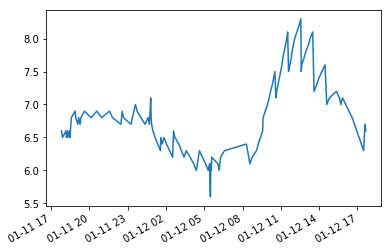

In [16]:
sensor_ds.plot()